<a href="https://colab.research.google.com/github/Karthik-Pydishetty/FashionMNISTClassifier/blob/main/Clothes_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

import torchvision
import torchvision.transforms as transforms

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
transform = transforms.ToTensor()

batch_size = 8

train_dataset = torchvision.datasets.FashionMNIST(root = './data', train = True,
                                                download=True, transform = transform)

test_dataset = torchvision.datasets.FashionMNIST(root = './data', train = False,
                                                download=True, transform = transform)

classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal'
        , 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


100%|██████████| 26421880/26421880 [00:02<00:00, 10056170.01it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 172988.00it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3199345.65it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6188672.11it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
train_iter = iter(train_dataset) # iterates over training dataset

image, label = next(train_iter) # Image and label pair which is next on the train iter

image.shape, label

# 1 color chanel height = 28 pixels, width 28 pixels

(torch.Size([1, 28, 28]), 9)

In [4]:
torch.min(image).item(), torch.max(image).item()

# min and max color of all pixels in image

(0.0, 1.0)

Ankle boot


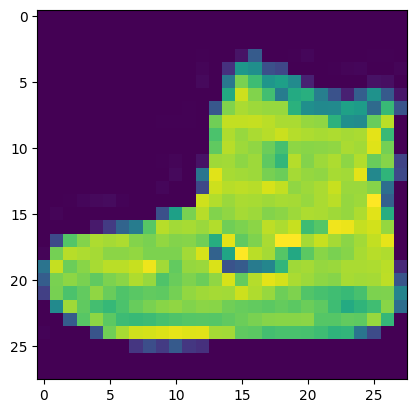

In [5]:
import matplotlib.pyplot as plt
import numpy as np

np_img = image.numpy()
print(classes[label])
plt.imshow(np_img.reshape((28, 28, 1))) # matplotlib requres num of channels to be in back

In [6]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [7]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000,10000])

# validation set is used to tune hyperparameters after every epoch

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle = True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle = False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                        shuffle = False, num_workers=2)

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Architecture of neural network
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3) # 1 color channel, 256 feature maps, 3 by 3 kernal (filter)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten() # flattens skinny image into a vector

        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3) # 30% chance of out features turning to 0, preventing overfitting

        self.fc2 = nn.Linear(in_features=1024, out_features=1024)
        self.drop2 = nn.Dropout(p=0.3)

        self.out = nn.Linear(in_features=1024, out_features=10)

    # Forward pass
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.out(x)

        return x

In [9]:
net = NeuralNet()
net.to(device)

NeuralNet(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)

In [10]:
for i, data in enumerate(train_loader):
    images, labels = data[0].to(device), data[1].to(device) # moves entire batch of images and labels and esnures all computation is done on same device
    print(f' input shape: {images.shape}')
    print(f'after network shape: {net(images).shape}') # batch size, num of feature maps, height, width
    break


 input shape: torch.Size([8, 1, 28, 28])
after network shape: torch.Size([8, 10])


In [11]:
num_params = 0
for x in net.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 8,536,074


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001) # adam optimizer adjusts learning rate accordingly

In [13]:
def train_one_epoch():
    net.train(True) # Neural net

    running_loss = 0.0

    running_accuracy = 0.0

    for batch_index, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device) # moves entire batch of images and labels to device

        optimizer.zero_grad()

        outputs = net(images) # shape [batchsize, 10]
        correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item() # torchargmax is vector of predictions
        running_accuracy += correct / batch_size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_index % 500 == 499:  # print every 500 batches
            avg_loss_across_batches = running_loss / 500
            avg_acc_across_batches = (running_accuracy / 500) * 100
            print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                        avg_loss_across_batches,
                                                        avg_acc_across_batches))
            running_loss = 0.0
            running_accuracy = 0.0

    print()

In [20]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0

    for i, data in enumerate(valid_loader):
        images, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            outputs = net(images) # shape: [batch_size, 10]
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, labels) # One number, the average batch loss
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valid_loader) # of batchs in validation set
    avg_acc_across_batches = (running_accuracy / len(valid_loader)) * 100

    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

In [15]:
num_epochs = 10

for epoch_index in range(num_epochs):
    print("Epoch: ", epoch_index)

    train_one_epoch()

    validate_one_epoch()



Epoch:  0
Batch 500, Loss: 1.182, Accuracy: 55.2%
Batch 1000, Loss: 0.722, Accuracy: 73.5%
Batch 1500, Loss: 0.664, Accuracy: 74.2%
Batch 2000, Loss: 0.586, Accuracy: 78.1%
Batch 2500, Loss: 0.549, Accuracy: 79.2%
Batch 3000, Loss: 0.508, Accuracy: 81.2%
Batch 3500, Loss: 0.506, Accuracy: 80.9%
Batch 4000, Loss: 0.479, Accuracy: 81.8%
Batch 4500, Loss: 0.467, Accuracy: 83.0%
Batch 5000, Loss: 0.458, Accuracy: 83.2%
Batch 5500, Loss: 0.412, Accuracy: 84.1%
Batch 6000, Loss: 0.430, Accuracy: 83.7%

Val Loss: 0.417, Val Accuracy: 84.3%
***************************************************

Epoch:  1
Batch 500, Loss: 0.396, Accuracy: 85.4%
Batch 1000, Loss: 0.364, Accuracy: 86.5%
Batch 1500, Loss: 0.366, Accuracy: 86.5%
Batch 2000, Loss: 0.369, Accuracy: 86.5%
Batch 2500, Loss: 0.367, Accuracy: 86.7%
Batch 3000, Loss: 0.337, Accuracy: 87.5%
Batch 3500, Loss: 0.349, Accuracy: 86.9%
Batch 4000, Loss: 0.352, Accuracy: 86.8%
Batch 4500, Loss: 0.342, Accuracy: 87.5%
Batch 5000, Loss: 0.335, Accur

In [33]:
# test
def test():
    net.train(False)  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    printed_images = 0
    classes = ('T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

    for i, data in enumerate(test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        total_samples += labels.size(0)
        with torch.no_grad():
            outputs = net(images)
            predictions = torch.argmax(outputs, dim=1)
            corrects = torch.sum(predictions == labels).item()
            running_corrects += corrects
            loss = criterion(outputs, labels)  # One number, the average batch loss
            running_loss += loss.item()

            # Print predictions and actual labels for the first 10 images
            if printed_images < 10:
                for j in range(min(batch_size, 10 - printed_images)):
                    print(f'Image {printed_images + 1}:')
                    print(f'Predicted: {classes[predictions[j].item()]}, Actual: {classes[labels[j].item()]}')
                    printed_images += 1
                if printed_images >= 10:
                    break

    avg_acc = (running_corrects / total_samples) * 100
    print(f'Final Average Accuracy: {avg_acc:.2f}%')

test()





Image 1:
Predicted: Ankle boot, Actual: Ankle boot
Image 2:
Predicted: Pullover shirt, Actual: Pullover shirt
Image 3:
Predicted: Trouser/pants, Actual: Trouser/pants
Image 4:
Predicted: Trouser/pants, Actual: Trouser/pants
Image 5:
Predicted: Shirt, Actual: Shirt
Image 6:
Predicted: Trouser/pants, Actual: Trouser/pants
Image 7:
Predicted: Coat, Actual: Coat
Image 8:
Predicted: Shirt, Actual: Shirt
Image 9:
Predicted: Sandal, Actual: Sandal
Image 10:
Predicted: Sneaker, Actual: Sneaker
Final Average Accuracy: 93.75%
